#### Chargement des librairies nécessaires

In [1]:
# Import de librairies
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import random
import scipy.stats as st
import statsmodels.api as sm
import sklearn.experimental
import sklearn.ensemble
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency as chi2_contingency
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.collections import LineCollection

In [2]:
# Charger seaborn
sns.set()

In [3]:
# Chargement du fichier
data = pd.read_csv("Dataset_projet_1.csv", sep = "\t", encoding = 'utf-8')

C:\Users\aguer\AppData\Local\Temp\ipykernel_19428\2163901634.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Dataset_projet_1.csv", sep = "\t", encoding = 'utf-8')


# 1) Description des données 

In [4]:
data.shape

(320772, 162)

~ 320 800 lignes et 162 colonnes, c'est donc un dataset plutôt conséquent. Il contient beaucoup d'informations qui ne seront certainement pas toutes importantes dans le cadre de notre projet. 

In [182]:
# Visualisation des données
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On remarque un nombre important de données, qui ne sont pas forcément bien formatées (date) et beaucoup de valeurs manquantes

In [4]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

On voit que les dates par exemple ne sont pas bien formatées

In [ ]:
data.info()

On remarque 2 types de données, des float et des objects

In [ ]:
data.describe()

En regardant les données, on s'aperçoit que des variables n'ont pas d'intérêt pour notre analyse car elles ne possèdent que des valeurs manquantes 

# 2) Nettoyage des données 

## 2.1 Filtrage general

In [4]:
# Comptabiliser les doublons
data.duplicated().sum() # Aucun doublon parfait 

0

Je fais le choix de ne garder que les produits vendus en France, car mon application sera destiné au public français dans un premier temps

In [40]:
count = 0
for line in data["countries_fr"].dropna() : 
    if (line.find('France') != -1):
        count+=1

print(count)

98440


In [41]:
count/len(data) * 100 # On conserve 31% des lignes environ si on se focalise sur les produits qui sont vendus en France

30.68846408040602

In [5]:
data = data[data["countries_fr"].str.find('France') != -1] 
# On selectionne les lignes qui sont vendus en France 

In [6]:
data.shape

(98720, 162)

In [5]:
print(data.columns.tolist())

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

En observant toutes les colonnes, on peut voir que certaines ne nous interessent pas dans le cadre de notre projet, comme par exemple la date ou encore le createur.  
Cela nous permet de commencer à verifier les données d'intérêt. Ensuite, nous utiliserons une technique de filtrage technique. 

In [54]:
data.shape

(98720, 162)

In [6]:
# Suppression des colonnes qui ne contiennent aucune données 
data.dropna(axis = 1, how = 'all', inplace = True) # Les colonnes sans aucune données
data.dropna(axis = 0, how = 'all', inplace = True) # Les lignes sans données 

In [8]:
data.shape

(98720, 136)

## 2.2 Filtrage technique

Il reste toujours 136 colonnes, nous allons donc fixer un seuil d'acceptation qui va nous permettre de réduire une fois de plus nos colonnes.

In [7]:
nb_na = data.isnull().sum() # On définit le nombre de valeurs nulles

In [8]:
seuil = 0.7*len(data) # Seuil d'acceptation à 70% 
seuil

69104.0

In [9]:
data.shape[1]-len(nb_na[nb_na>seuil]) 
# 53 colonnes dépassent le seuil d'acceptation choisi, ce qui me paraît être un bon résultat

53

In [10]:
# On supprime les colonnes qui ne dépassent pas le seuil défini
to_drop = nb_na[nb_na>seuil].index
data = data.drop(to_drop, axis = 1)

## 2.3 Filtrage métier

In [57]:
data.head() # On regarde les colonnes qui n'ont pas vraiment leur importance dans notre analyse

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,24600,http://world-fr.openfoodfacts.org/produit/0000...,date-limite-app,1434530704,2015-06-17T08:45:04Z,1434535914,2015-06-17T10:11:54Z,Filet de bœuf,NaN,2.46 kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,27205,http://world-fr.openfoodfacts.org/produit/0000...,tacinte,1458238630,2016-03-17T18:17:10Z,1458238638,2016-03-17T18:17:18Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,36252,http://world-fr.openfoodfacts.org/produit/0000...,tacinte,1422221701,2015-01-25T21:35:01Z,1489055667,2017-03-09T10:34:27Z,Lion Peanut x2,NaN,NaN,...,20.0,12.5,70.0,57.5,2.5,2.5,0.09652,0.038,22.0,22.0
136,39259,http://world-fr.openfoodfacts.org/produit/0000...,tacinte,1422221773,2015-01-25T21:36:13Z,1473538082,2016-09-10T20:08:02Z,Twix x2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Suppression des colonnes sans intérêt dans le cadre de notre projet, on garde l'url pour remonter à notre produit

data.drop(["created_t","created_datetime","last_modified_t", "last_modified_datetime"], axis = 1, inplace = True) 
# On retire la date car nous n'en avons pas besoin dans notre analyse

data.drop(["countries","countries_tags","states", "states_tags", "countries_fr"], axis = 1, inplace = True) 
# On supprime car c'est une information qui se repete, juste avec des termes différents et qu'on a filtré sur les produits français

data.drop("creator", axis = 1, inplace = True) # Le createur ne nous sert pas à grand chose
data.drop("additives_tags", axis = 1, inplace = True) # Redondant avec les additif en francais, qui contiennent assez d'infos
data.drop("brands_tags", axis = 1, inplace = True) # Redondant par rapport à la variable brand
data.drop("code", axis = 1, inplace = True)
# On supprime le code car il n'a, selon moi, pas d'importance car il n'apporte rien dans l'analyse 

data.drop("states_fr", axis = 1, inplace = True) # Pour moi, l'etat de completion des informations produits n'est pas important
data.drop("nutrition-score-uk_100g", axis = 1, inplace = True) 
# Je considère que l'application sera deployé dans un premier temps à destination d'un public français, puis à l'international par la suite
# Peut être également que l'information contenue dans ces 2 variables est finalement identique

data.drop("generic_name", axis = 1, inplace = True)
to_drop2 = ["brands", "quantity","categories_tags","categories","categories_fr","main_category","packaging", "packaging_tags", "image_url", "image_small_url", "purchase_places", "stores", "labels_tags", "labels" ]
# Je decide de supprimer ces elements car ce ne sont pas ceux qui ont le plus d'importance à mon goût

data.drop(to_drop2, axis = 1, inplace = True)
data.drop(["pnns_groups_1", "pnns_groups_2", "labels_fr"], axis = 1, inplace = True)
data.drop(["ingredients_text", "additives", "additives_fr"], axis = 1, inplace = True)

In [13]:
data.columns

Index(['url', 'product_name', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'main_category_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [12]:
# On réinitialise les indexs 
data = data.reset_index(drop=True)

In [15]:
data.shape

(98720, 17)

On se retrouve avec 17 colonnes, on passe donc de 162 colonnes à 17 colonnes en passant par un filtrage technique puis par un filtrage métier.

On crée une matrice des corrélations pour voir les variables très corrélées entre elles, cela nous permettra d'en conserver 1 sur les 2 et donc de réduire la dimension du jeu de données 

In [16]:
data.corr()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
additives_n,1.000000,0.249994,0.429505,-0.001847,-0.019944,-0.018393,0.126852,0.133026,-0.102535,-0.088278,0.003656,0.003648,0.208359
ingredients_from_palm_oil_n,0.249994,1.000000,0.168230,0.010823,0.124819,0.157453,0.247079,0.198679,0.030960,-0.045337,0.015165,0.015162,0.270497
ingredients_that_may_be_from_palm_oil_n,0.429505,0.168230,1.000000,0.004292,0.053746,0.050695,0.144211,0.061495,-0.030974,-0.063824,-0.012023,-0.012027,0.133654
energy_100g,-0.001847,0.010823,0.004292,1.000000,0.037230,0.031760,0.030089,0.017057,0.023487,0.019550,-0.002529,-0.002529,0.033306
fat_100g,-0.019944,0.124819,0.053746,0.037230,1.000000,0.740690,-0.069341,0.002971,0.077177,0.140984,0.009691,0.009687,0.573339
saturated-fat_100g,-0.018393,0.157453,0.050695,0.031760,0.740690,1.000000,-0.020901,0.080183,0.019328,0.143427,0.008259,0.008256,0.600641
carbohydrates_100g,0.126852,0.247079,0.144211,0.030089,-0.069341,-0.020901,1.000000,0.639856,0.245263,-0.129080,-0.079717,-0.079715,0.244338
sugars_100g,0.133026,0.198679,0.061495,0.017057,0.002971,0.080183,0.639856,1.000000,0.035964,-0.245799,-0.085971,-0.085977,0.453579
fiber_100g,-0.102535,0.030960,-0.030974,0.023487,0.077177,0.019328,0.245263,0.035964,1.000000,0.197800,0.002916,0.002921,-0.124076
proteins_100g,-0.088278,-0.045337,-0.063824,0.019550,0.140984,0.143427,-0.129080,-0.245799,0.197800,1.000000,0.092600,0.092607,0.094909


On remarque une corrélation evidente entre le sel et le sodium (1), donc on va retirer la colonne qui contient le moins de valeur

In [17]:
data.isna().mean()

url                                        0.000000
product_name                               0.073389
additives_n                                0.457536
ingredients_from_palm_oil_n                0.457536
ingredients_that_may_be_from_palm_oil_n    0.457536
nutrition_grade_fr                         0.377310
main_category_fr                           0.371363
energy_100g                                0.344996
fat_100g                                   0.516744
saturated-fat_100g                         0.367534
carbohydrates_100g                         0.521100
sugars_100g                                0.366137
fiber_100g                                 0.536578
proteins_100g                              0.347832
salt_100g                                  0.365519
sodium_100g                                0.365549
nutrition-score-fr_100g                    0.377310
dtype: float64

In [13]:
# On retire la colonne du sodium car celle du sel nous permet de l'exprimer
data.drop("sodium_100g", axis = 1, inplace = True)

In [14]:
# On remplace les - par des _ dans le nom des colonnes, ce qui va faciliter les choses pour la suite. 
data.columns = data.columns.str.replace('-','_')

## 2.3 Valeurs aberrantes

On s'intéresse à présent aux valeurs aberrantes

In [18]:
data.shape

(98720, 16)

In [97]:
data.describe() 
# On regarde en premier lieu les variables quantitatives 

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,53552.000000,53552.000000,53552.00000,6.466200e+04,47707.000000,62437.000000,47277.000000,62575.000000,45749.000000,64382.000000,62636.000000,61472.000000
mean,1.855449,0.069820,0.14808,1.171551e+03,13.336371,5.426045,27.764742,13.436107,2.560812,7.754874,1.160413,8.683726
std,2.560380,0.258556,0.45049,1.282908e+04,16.932307,8.540222,27.413456,19.090192,4.637408,7.887673,4.308340,9.045923
min,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,-15.000000
25%,0.000000,0.000000,0.00000,4.270000e+02,1.300000,0.300000,4.000000,1.000000,0.000000,1.800000,0.080000,1.000000
50%,1.000000,0.000000,0.00000,1.035000e+03,6.800000,2.000000,14.500000,4.100000,1.390000,6.000000,0.558800,9.000000
75%,3.000000,0.000000,0.00000,1.650000e+03,21.000000,7.400000,53.000000,17.800000,3.200000,11.000000,1.244600,15.000000
max,31.000000,2.000000,5.00000,3.251373e+06,380.000000,210.000000,190.000000,105.000000,178.000000,100.000000,211.000000,40.000000


On regarde les donnéees qui sont soit supérieures à 100 ou soit inférieures à 0, sauf dans le cas de 2 colonnes qui sont des exceptions.  
On va ensuite remplacer ces valeurs par des NaN car on a pas encore traité ces valeurs

In [70]:
data2 = data.drop('nutrition_score_fr_100g', axis = 1)
for elem in data2.columns :
    if data[elem].dtypes == 'float64' :
        print("Variable :", elem)
        print("nombre de valeur :", len(data[data[elem]<0]))
        print("Pourcentage : ", len(data[data[elem]<0])/len(data)*100)
# Sur les 12 variables quantitatives, on voit que 1 seule contient des valeurs négatives
# Dans cette variable, 1 seule valeur est négative ce qui correspond à 0,001% de la colonne, ce qui est négligeable donc on peut la supprimer sans problème 

Variable : additives_n
nombre de valeur : 0
Pourcentage :  0.0
Variable : ingredients_from_palm_oil_n
nombre de valeur : 0
Pourcentage :  0.0
Variable : ingredients_that_may_be_from_palm_oil_n
nombre de valeur : 0
Pourcentage :  0.0
Variable : energy_100g
nombre de valeur : 0
Pourcentage :  0.0
Variable : fat_100g
nombre de valeur : 0
Pourcentage :  0.0
Variable : saturated_fat_100g
nombre de valeur : 0
Pourcentage :  0.0
Variable : carbohydrates_100g
nombre de valeur : 0
Pourcentage :  0.0
Variable : sugars_100g
nombre de valeur : 1
Pourcentage :  0.001012965964343598
Variable : fiber_100g
nombre de valeur : 0
Pourcentage :  0.0
Variable : proteins_100g
nombre de valeur : 0
Pourcentage :  0.0
Variable : salt_100g
nombre de valeur : 0
Pourcentage :  0.0


In [15]:
# Creation d'une fonction qui va assigner la valeur 0 aux valeurs inférieures à 0, puisqu'on a 1 seule valeur sur tout le dataset, ça ne va pas modifier nos données
# Dans le cadre de notre projet, on ne peut pas avoir de valeurs négatives pour des valeurs nutritionnelles, regarder pour le nutri score 
data2 = data.drop('nutrition_score_fr_100g', axis = 1)
# Il est possible d'avoir un nutri score inférieur à 0, en particulier un nutri-score = -15 -> nutri grade = a 
# Plus le nutriscore est faible est plus le nutrigrade sera bon 
for elem in data2.columns :
    if data[elem].dtypes == 'float64' : 
        data.loc[data[elem] < 0, elem] = 0.0

In [72]:
# On fait la meme chose pour les valeurs supérieures à 100
data2 = data.drop('energy_100g', axis = 1)
for elem in data2.columns :
    if data[elem].dtypes == 'float64' :
        print("Variable :", elem)
        print("nombre de valeur :", len(data[data[elem] > 100]))
        print("Pourcentage : ", len(data[data[elem] > 100])/len(data)*100)

Variable : additives_n
nombre de valeur : 0
Pourcentage :  0.0
Variable : ingredients_from_palm_oil_n
nombre de valeur : 0
Pourcentage :  0.0
Variable : ingredients_that_may_be_from_palm_oil_n
nombre de valeur : 0
Pourcentage :  0.0
Variable : fat_100g
nombre de valeur : 2
Pourcentage :  0.002025931928687196
Variable : saturated_fat_100g
nombre de valeur : 1
Pourcentage :  0.001012965964343598
Variable : carbohydrates_100g
nombre de valeur : 8
Pourcentage :  0.008103727714748784
Variable : sugars_100g
nombre de valeur : 4
Pourcentage :  0.004051863857374392
Variable : fiber_100g
nombre de valeur : 1
Pourcentage :  0.001012965964343598
Variable : proteins_100g
nombre de valeur : 0
Pourcentage :  0.0
Variable : salt_100g
nombre de valeur : 2
Pourcentage :  0.002025931928687196
Variable : nutrition_score_fr_100g
nombre de valeur : 0
Pourcentage :  0.0


In [16]:
# On remplace également les valeurs qui sont supérieures à 100, sauf pour l'energie car l'unité est en kj
data2 = data.drop('energy_100g', axis = 1)

for elem in data2.columns :
    if data[elem].dtypes == 'float64' : 
        data.loc[data[elem] > 100, elem] = np.nan

<AxesSubplot:>

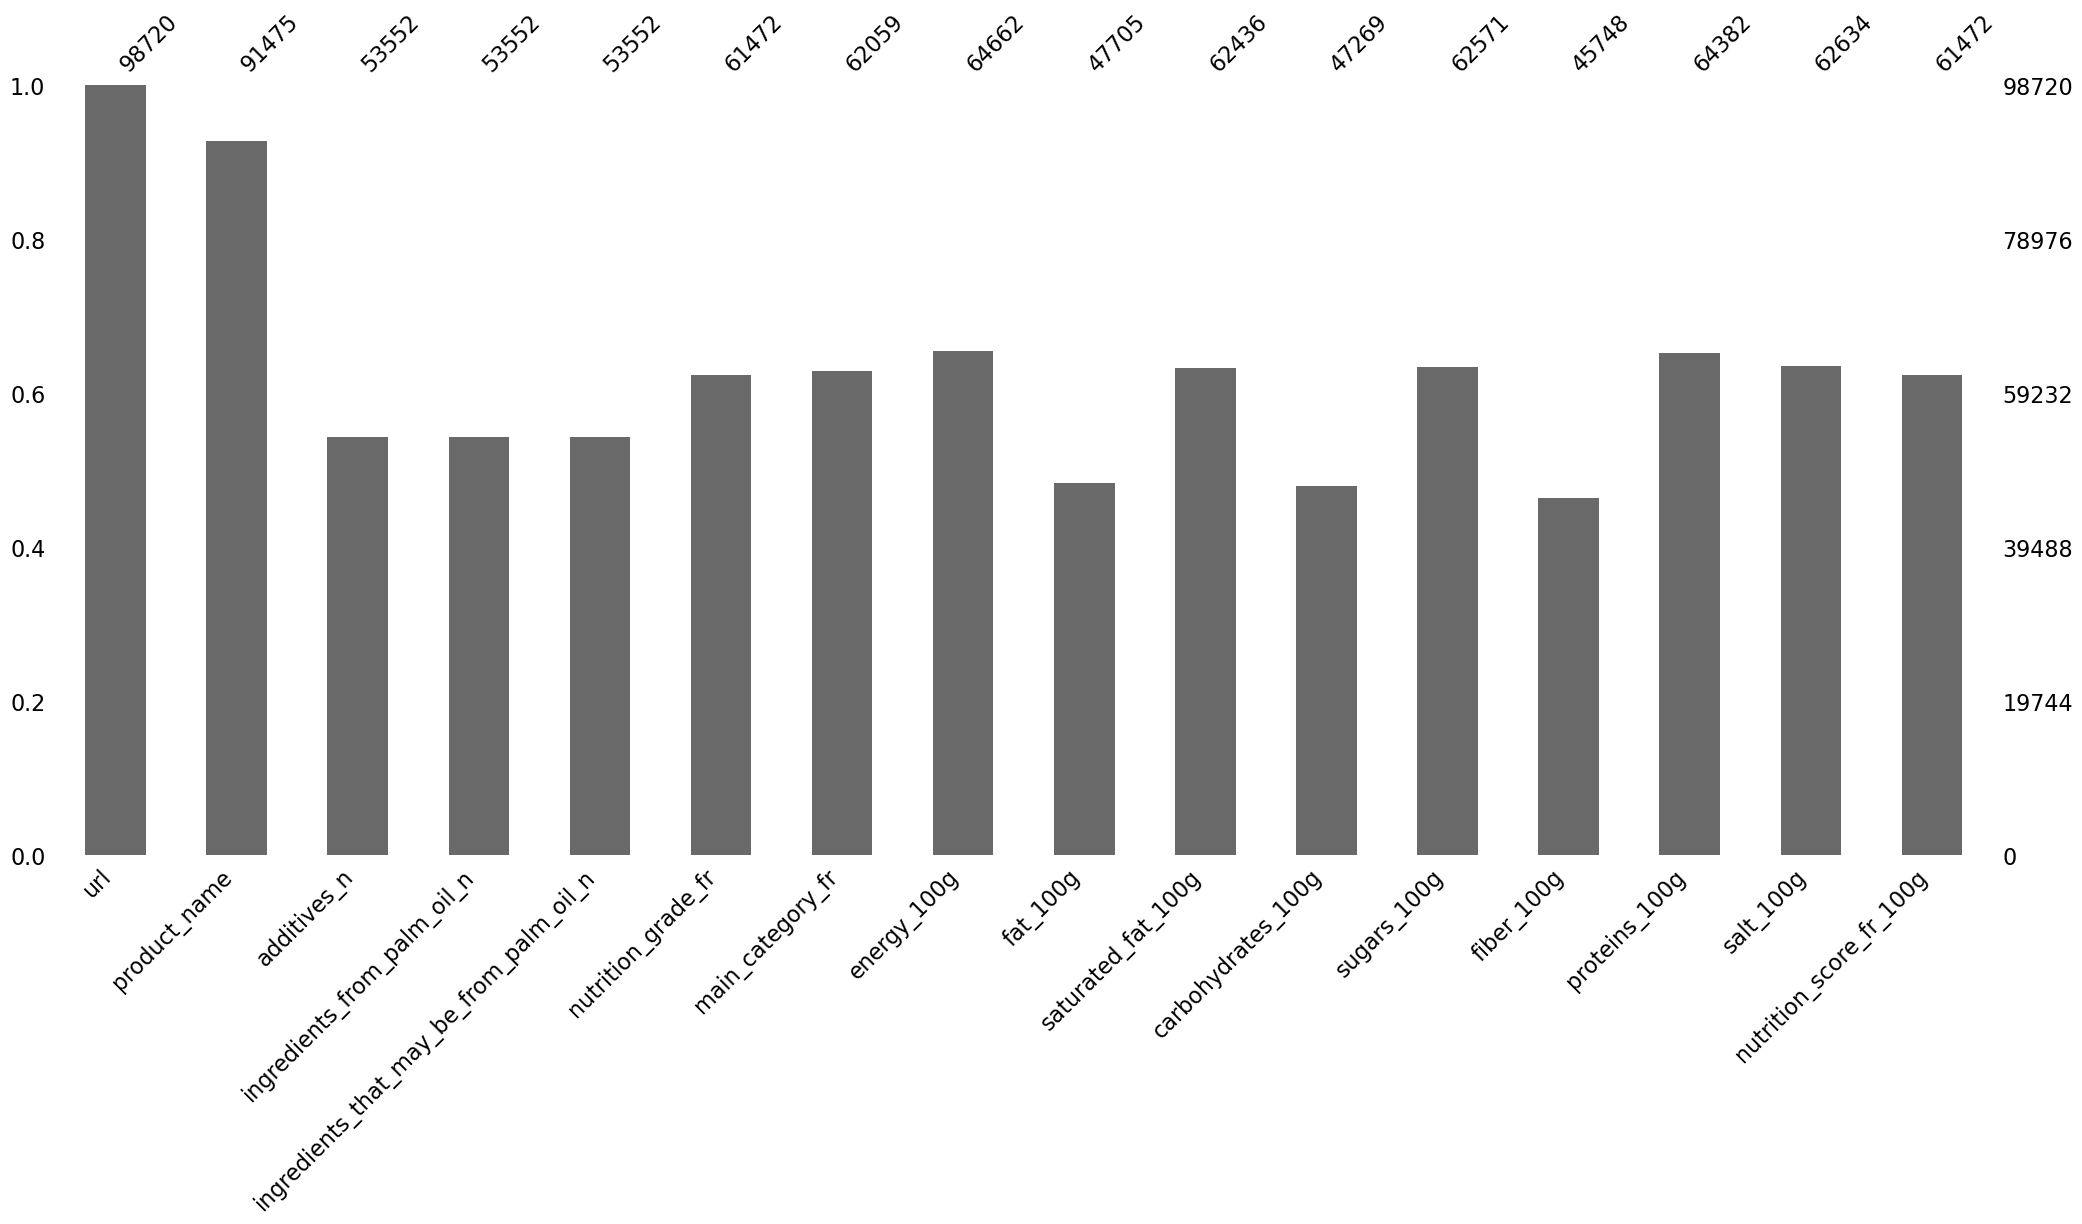

In [23]:
# On regarde nos valeurs manquantes, pour voir comment elles se distribuent 
msno.bar(data)

In [17]:
# On supprime à nouveau les lignes qui ne contiennent que des valeurs nulles 
data.dropna(axis = 0, how='all', inplace = True)

On supprime les lignes qui n'ont pas de nutriscore et nutrigrade car ça nous permet pas de remplir les autres valeurs, si on observe plus de valeurs pour certaines colonnes, on suppose que ce sont les valeurs aberrantes
En effet, le nutriscore est notre colonne d'intérêt et comme on ne peut la remplir si on a pas les informations, il est preferable de la retirer
On pourrait essayer de les garder mais ça va nous rajouter du biais sinon car on ne peut pas faire du remplissage en s'appuyant sur autre chose. On pourrait le faire mais si il manque une des variables nécessaires au calcul du nutriscore cela va poser problème. On pourrait imputer les variables puis le faire mais cela va rajouter du biais.  
On a pas forcement le temps de traiter ça. 

In [18]:
print(round(len(data[data["nutrition_score_fr_100g"].isna() & data["nutrition_grade_fr"].isna()])/len(data)*100,2),"%")
# Cela correspond tout de même à 37% du dataset

37.73 %


In [19]:
# On retire les lignes qui ne contiennent pas de nutriscore ET de nutrigrade
condition = data[data["nutrition_score_fr_100g"].isna() & data["nutrition_grade_fr"].isna()]
data.drop(condition.index, inplace=True)

In [20]:
data.shape
# On se retrouve avec 61 472 lignes et 16 colonnes

(61472, 16)

<AxesSubplot:>

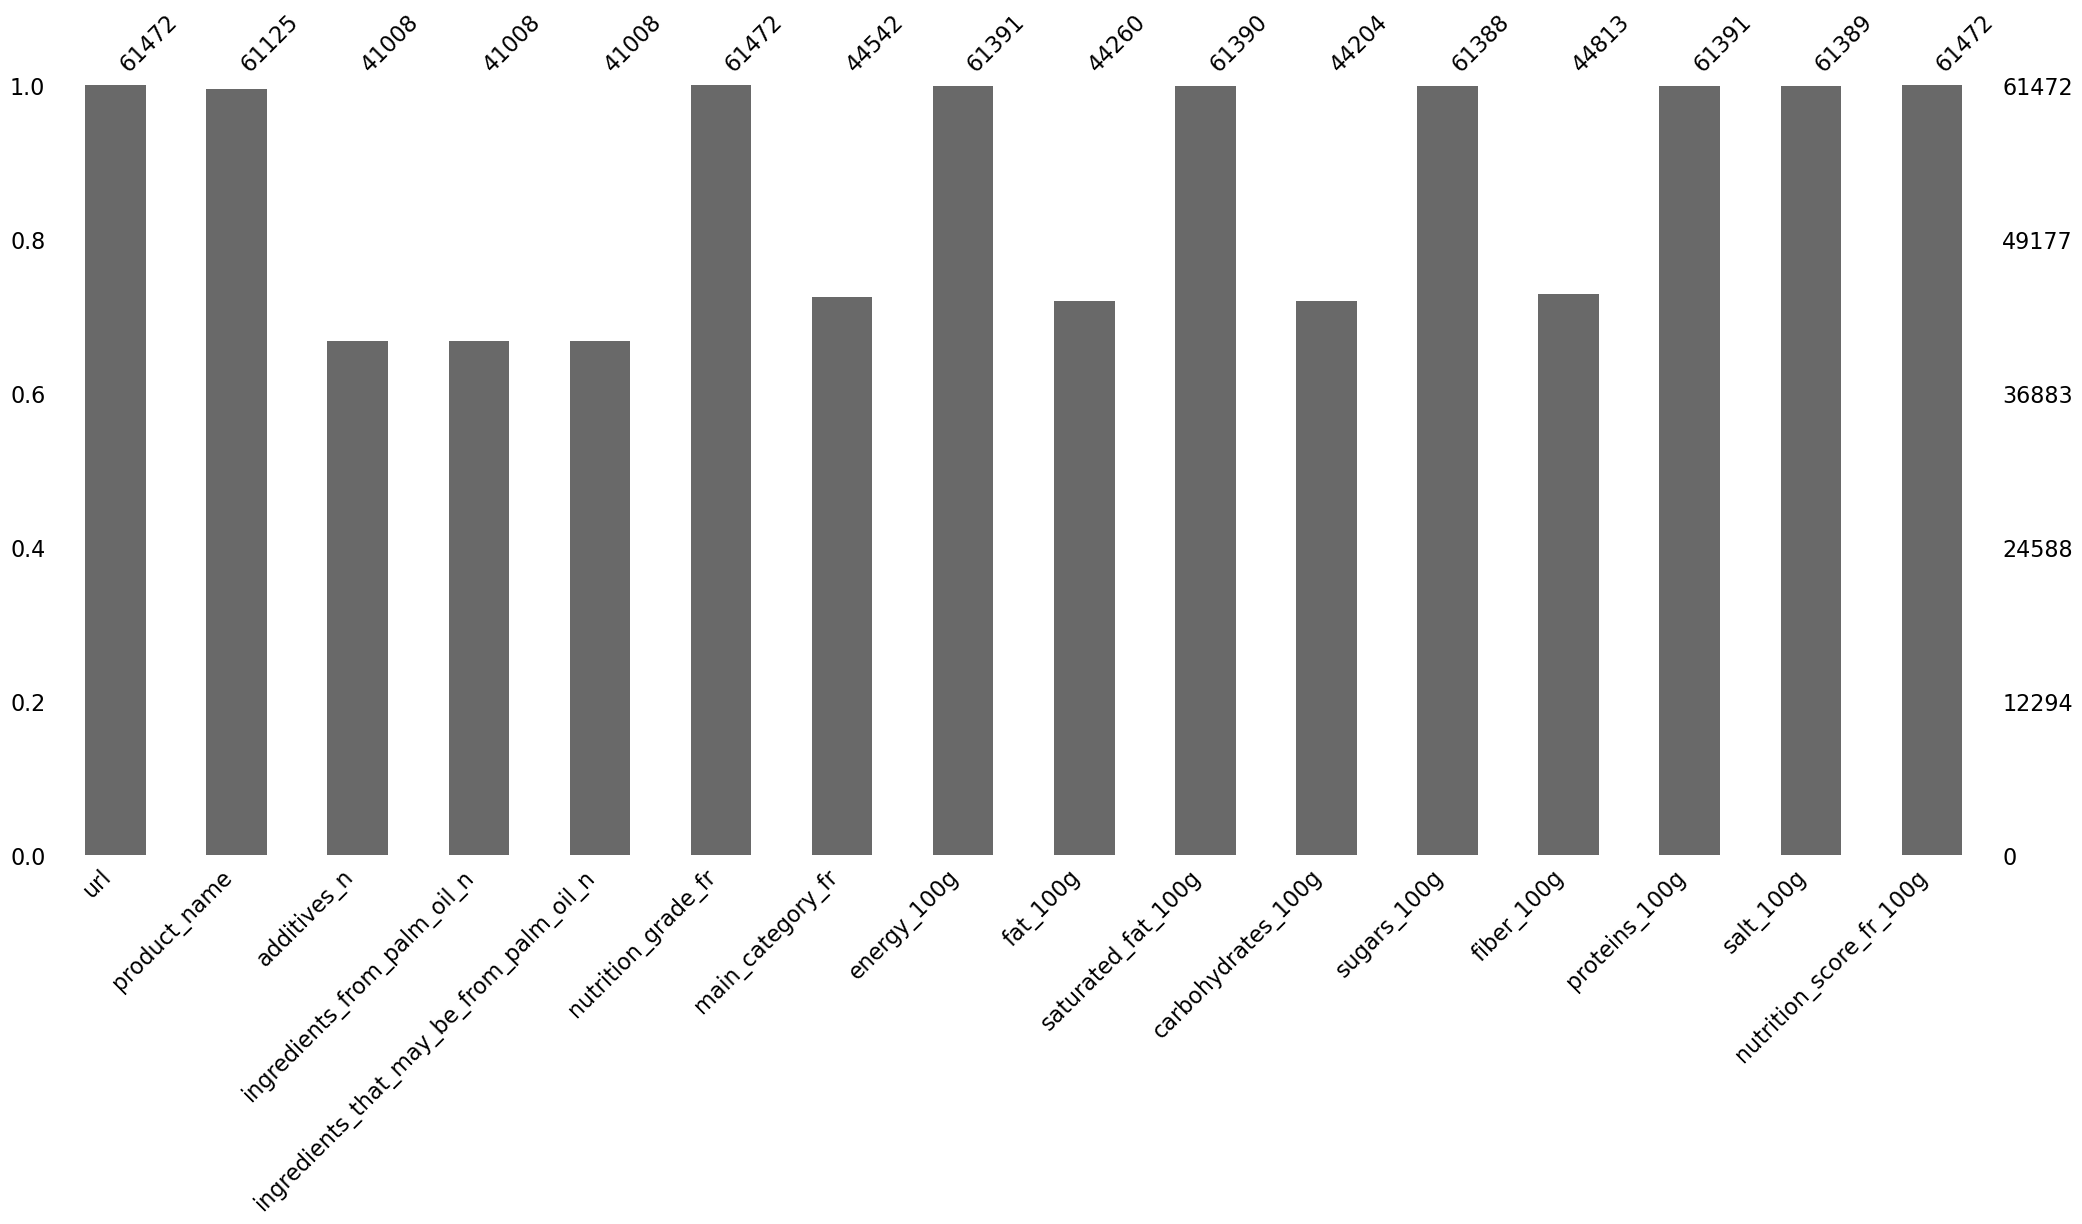

In [27]:
msno.bar(data)

In [106]:
print(data["ingredients_from_palm_oil_n"].value_counts())
print(data["ingredients_from_palm_oil_n"].value_counts()/len(data)*100)
print(data["ingredients_from_palm_oil_n"].value_counts().sum())
print("pourcentage de valeur manquantes pour ingredients_from_palm_oil_n",round(data["ingredients_from_palm_oil_n"].isna().sum()/len(data)*100,2))
print("valeurs nulles pour ingredients_from_palm_oil_n :",data["ingredients_from_palm_oil_n"].isna().sum())
print("valeurs non nulles pour ingredients_from_palm_oil_n :",data["ingredients_from_palm_oil_n"].notna().sum())
print("Verification : ",data["ingredients_from_palm_oil_n"].isna().sum()+data["ingredients_from_palm_oil_n"].notna().sum()==len(data) )

0.0    37801
1.0     3164
2.0       43
Name: ingredients_from_palm_oil_n, dtype: int64
0.0    61.493037
1.0     5.147059
2.0     0.069951
Name: ingredients_from_palm_oil_n, dtype: float64
41008
pourcentage de valeur manquantes pour ingredients_from_palm_oil_n 33.29
valeurs nulles pour ingredients_from_palm_oil_n : 20464
valeurs non nulles pour ingredients_from_palm_oil_n : 41008
Verification :  True


In [107]:
print(data["ingredients_that_may_be_from_palm_oil_n"].value_counts())
print(data["ingredients_that_may_be_from_palm_oil_n"].value_counts()/len(data)*100)
print(data["ingredients_that_may_be_from_palm_oil_n"].value_counts().sum())
print(data["ingredients_that_may_be_from_palm_oil_n"].isna().sum()/len(data)*100)
print("valeurs nulles pour ingredients_that_may_be_from_palm_oil_n :",data["ingredients_that_may_be_from_palm_oil_n"].isna().sum())
print("valeurs non nulles pour ingredients_that_may_be_from_palm_oil_n :",data["ingredients_that_may_be_from_palm_oil_n"].notna().sum())
print("Verification : ",data["ingredients_that_may_be_from_palm_oil_n"].isna().sum()+data["ingredients_that_may_be_from_palm_oil_n"].notna().sum()==len(data) )

0.0    35677
1.0     4188
2.0      898
3.0      214
4.0       28
5.0        3
Name: ingredients_that_may_be_from_palm_oil_n, dtype: int64
0.0    58.037806
1.0     6.812858
2.0     1.460828
3.0     0.348126
4.0     0.045549
5.0     0.004880
Name: ingredients_that_may_be_from_palm_oil_n, dtype: float64
41008
33.289953149401356
valeurs nulles pour ingredients_that_may_be_from_palm_oil_n : 20464
valeurs non nulles pour ingredients_that_may_be_from_palm_oil_n : 41008
Verification :  True


In [108]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,41008.000000,41008.000000,41008.000000,6.139100e+04,44260.000000,61390.000000,44204.000000,61388.000000,44813.000000,61391.000000,61389.000000,61472.000000
mean,2.050527,0.079253,0.164675,1.181610e+03,13.330374,5.435314,27.801524,13.397750,2.539692,7.741528,1.076183,8.683726
std,2.614199,0.273991,0.471515,1.316510e+04,16.671080,8.513680,27.249909,19.019125,4.541665,7.840588,3.677945,9.045923
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,0.000000,0.000000,0.000000,4.350000e+02,1.400000,0.300000,4.100000,1.000000,0.000000,1.900000,0.080000,1.000000
50%,1.000000,0.000000,0.000000,1.041000e+03,7.000000,2.000000,14.895000,4.000000,1.380000,6.000000,0.551180,9.000000
75%,3.000000,0.000000,0.000000,1.661000e+03,21.000000,7.400000,53.000000,17.900000,3.200000,10.800000,1.230000,15.000000
max,31.000000,2.000000,5.000000,3.251373e+06,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000


#### Approche interquartile pour les outliers

In [109]:
count = 0
coeff = 1.5
for elem in data2.columns :
    if data[elem].dtypes == 'float64' :
        IQR = stats.iqr(data[elem].dropna())
        Q1 = np.percentile(data[elem].dropna(), 25, interpolation = 'midpoint') 
        Q2 = np.percentile(data[elem].dropna(), 50, interpolation = 'midpoint') 
        Q3 = np.percentile(data[elem].dropna(), 75, interpolation = 'midpoint')
        low_lim = Q1 - coeff * IQR # essayer de jouer peut être sur le coefficient pour avoir moins de valeurs
        up_lim = Q3 + coeff * IQR
        n = len(data.loc[(data[elem] < low_lim) | (data[elem] > up_lim), elem])
        pourcentage = n/len(data)*100
        print("Variable :", elem)
        print("nombre de valeur :", n)
        print("Pourcentage : ", round(pourcentage,2), "%")
        count += n
        
# On remarque qu'on a moins de 10% de valeurs aberrantes pour chaque variable donc on peut se permettre de garder ce coefficient 
# Faire un boxplot pour mieux visualiser les propos 

Variable : additives_n
nombre de valeur : 1905
Pourcentage :  3.1 %
Variable : ingredients_from_palm_oil_n
nombre de valeur : 3207
Pourcentage :  5.22 %
Variable : ingredients_that_may_be_from_palm_oil_n
nombre de valeur : 5331
Pourcentage :  8.67 %
Variable : fat_100g
nombre de valeur : 1553
Pourcentage :  2.53 %
Variable : saturated-fat_100g
nombre de valeur : 4462
Pourcentage :  7.26 %
Variable : carbohydrates_100g
nombre de valeur : 0
Pourcentage :  0.0 %
Variable : sugars_100g
nombre de valeur : 6102
Pourcentage :  9.93 %
Variable : fiber_100g
nombre de valeur : 2819
Pourcentage :  4.59 %
Variable : proteins_100g
nombre de valeur : 2520
Pourcentage :  4.1 %
Variable : salt_100g
nombre de valeur : 3194
Pourcentage :  5.2 %
Variable : nutrition-score-fr_100g
nombre de valeur : 1
Pourcentage :  0.0 %


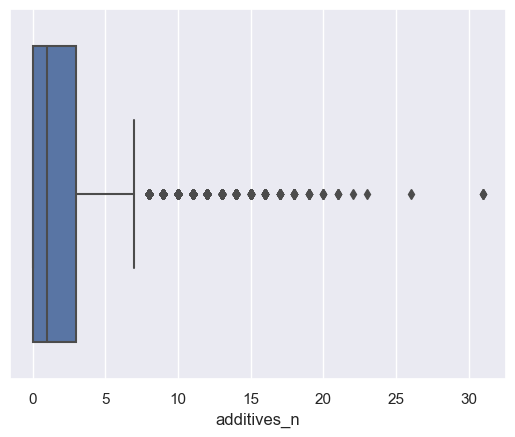

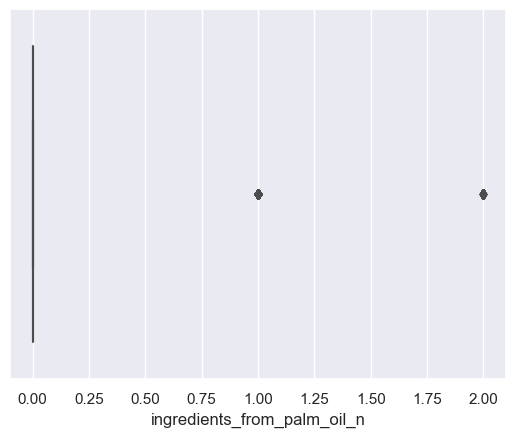

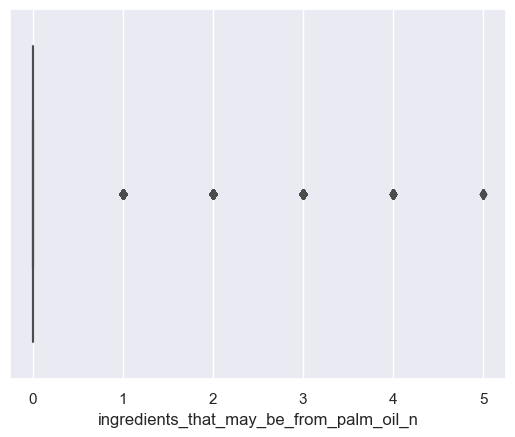

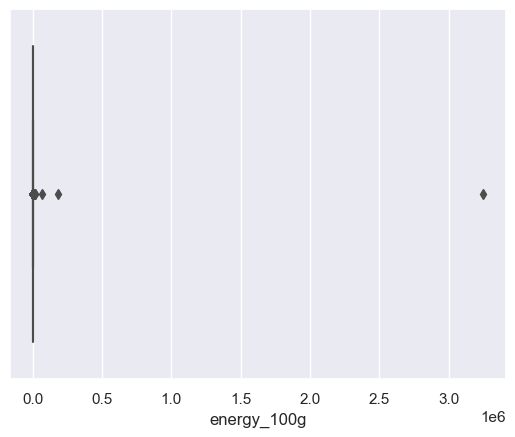

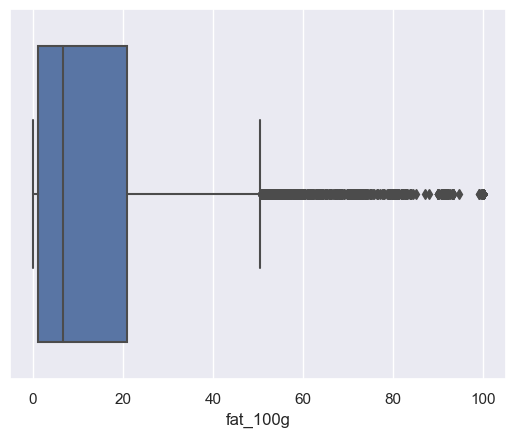

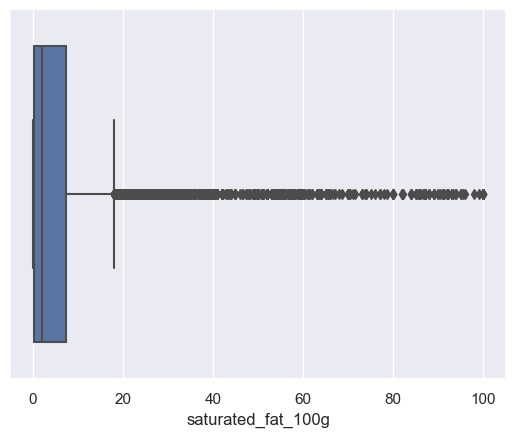

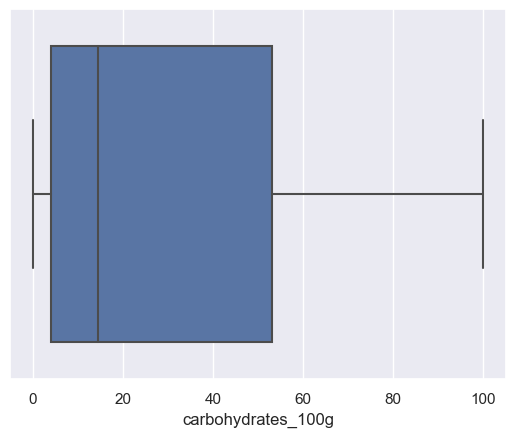

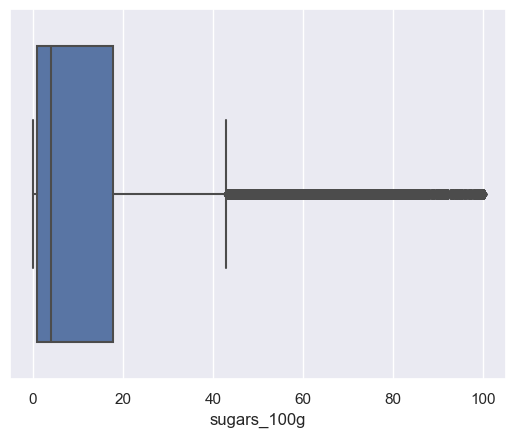

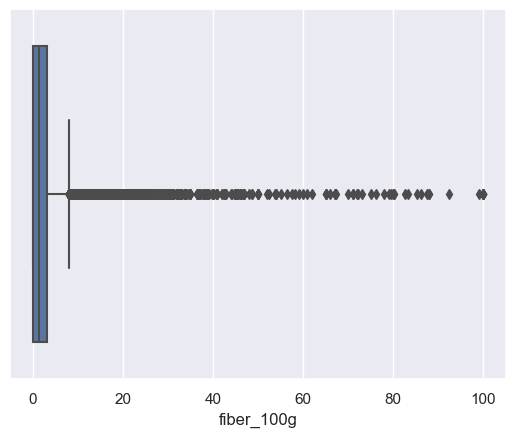

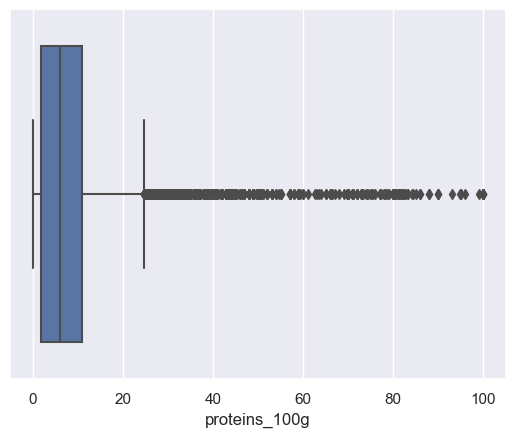

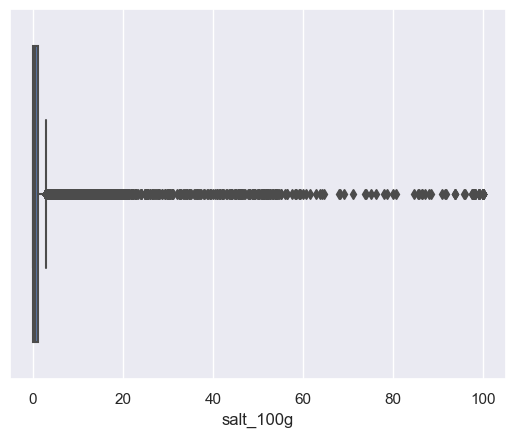

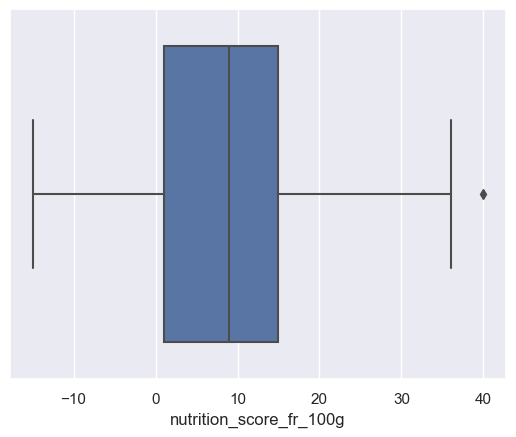

In [78]:
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        sns.boxplot(x=data[elem])
        plt.show()

In [22]:
# Calcul pour huile de palme 
nul = len(data[data["ingredients_from_palm_oil_n"] == 0.0])
n = len(data[data["ingredients_from_palm_oil_n"].isna()])
print(nul,"valeurs de ingredients_from_palm_oil_n ont pour valeur 0 soit",round(nul/len(data)*100,2),"%")
print(n,"valeurs de ingredients_from_palm_oil_n sont nulles soit",round(n/len(data)*100,2),"%")
# Pourcentage de valeur qui seront égales à 0 après imputation, car la moyenne de la colonne sera surement très proche de 0 :
print("Pourcentage de valeur de ingredients_from_palm_oil_n qui seront égales à 0 après imputation :",round((nul+n)/len(data)*100,2),"%")

37801 valeurs de ingredients_from_palm_oil_n ont pour valeur 0 soit 61.49 %
20464 valeurs de ingredients_from_palm_oil_n sont nulles soit 33.29 %
Pourcentage de valeur de ingredients_from_palm_oil_n qui seront égales à 0 après imputation : 94.78 %


In [23]:
# Calcul pour ceux qui peuvent avoir huile de palme 
nul2 = len(data[data["ingredients_that_may_be_from_palm_oil_n"] == 0.0])
n2 = len(data[data["ingredients_that_may_be_from_palm_oil_n"].isna()])
print(nul2,"valeurs de ingredients_that_may_be_from_palm_oil_n ont pour valeur 0 soit",round(nul2/len(data)*100,2),"%")
print(n2,"valeurs de ingredients_that_may_be_from_palm_oil_n sont nulles soit",round(n2/len(data)*100,2),"%")
# Pourcentage de valeur qui seront égales à 0 après imputation, car la moyenne de la colonne sera surement très proche de 0 :
print("Pourcentage de valeur de ingredients_that_may_be_from_palm_oil_n qui seront égales à 0 après imputation :",round((nul2+n2)/len(data)*100,2),"%")


35677 valeurs de ingredients_that_may_be_from_palm_oil_n ont pour valeur 0 soit 58.04 %
20464 valeurs de ingredients_that_may_be_from_palm_oil_n sont nulles soit 33.29 %
Pourcentage de valeur de ingredients_that_may_be_from_palm_oil_n qui seront égales à 0 après imputation : 91.33 %


Quand on observe les variables à l'aide d'un boxplot, on voit que certaines variables sont bien representées, sans valeurs aberrantes.  
On retiendra les variables suivantes, qui ne nécessitent pas de modification : nutrition-score-fr_100g, carbohydrates_100g.  
Les variables ingredients_from_palm_oil_n et ingredients_that_may_be_from_palm_oil_n se concentrent enormement sur 0, donc 2 choix s'offrent à nous : 
- Soit on les garde et on aura une très forte concentration de valeur égale à 0 (94.78% pour ingredients_from_palm_oil_n et 91.33% pour ingredients_that_may_be_from_palm_oil_n)
- Soit on les supprime car ces 2 colonnes ne nous apportent pas beaucoup d'informations.  
  
Nous opterons plutôt pour la 2eme solution car on voit dans les 2 cas, plus de 90% des données auront pour valeur 0 

In [21]:
data.drop(["ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n"], axis = 1, inplace = True)

In [37]:
data.shape

(61472, 14)

In [22]:
supp = data.drop('url', axis = 1).columns
supp

Index(['product_name', 'additives_n', 'nutrition_grade_fr', 'main_category_fr',
       'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'nutrition_score_fr_100g'],
      dtype='object')

In [23]:
# On supprime les doublons en ne prenant pas en compte l'url
data.drop_duplicates(subset = supp, keep = 'first', inplace=True)

On remarque que beaucoup de nos variables ont des outliers.  
Cependant, ce ne sont pas des valeurs aberrantes mais dans l'ensemble des valeurs atypiques. Cela nous prendrait trop de temps de filtrer chaque colonne en utilisant des informations externes pour conserver certaines valeurs (comme le sel qui a une forte concentration en sodium ou les produits de la mer ou encore le sucre ou les bonbons avec une forte teneur en sucre).  
On décide donc de traiter les variables avec la méthode interquartile. 

In [157]:
'''
coeff = 1.5
var = 'energy_100g'

IQR = stats.iqr(data[var].dropna())
Q1 = np.percentile(data[var].dropna(), 25, interpolation = 'midpoint') 
Q2 = np.percentile(data[var].dropna(), 50, interpolation = 'midpoint') 
Q3 = np.percentile(data[var].dropna(), 75, interpolation = 'midpoint')
low_lim = Q1 - coeff * IQR 
up_lim = Q3 + coeff * IQR
print(len(data.loc[(data[var] < low_lim) | (data[var] > up_lim), var]),"valeurs vont être modifiées")
data.loc[(data[var] < low_lim) | (data[var] > up_lim), var] = np.nan
'''

'\ncoeff = 1.5\nvar = \'energy_100g\'\n\nIQR = stats.iqr(data[var].dropna())\nQ1 = np.percentile(data[var].dropna(), 25, interpolation = \'midpoint\') \nQ2 = np.percentile(data[var].dropna(), 50, interpolation = \'midpoint\') \nQ3 = np.percentile(data[var].dropna(), 75, interpolation = \'midpoint\')\nlow_lim = Q1 - coeff * IQR \nup_lim = Q3 + coeff * IQR\nprint(len(data.loc[(data[var] < low_lim) | (data[var] > up_lim), var]),"valeurs vont être modifiées")\ndata.loc[(data[var] < low_lim) | (data[var] > up_lim), var] = np.nan\n'

In [158]:
# Compter le nombre d'outliers selon le coefficient 1.5 et grâce à l'ecart interquartile 
coeff = 1.5
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        IQR = stats.iqr(data[elem].dropna())
        Q1 = np.percentile(data[elem].dropna(), 25, interpolation = 'midpoint') 
        Q3 = np.percentile(data[elem].dropna(), 75, interpolation = 'midpoint')
        low_lim = Q1 - coeff * IQR 
        up_lim = Q3 + coeff * IQR
        print("Le pourcentage de",elem,"qui dépassent la borne maximale est :", round(len(data[data[elem]>up_lim])/len(data)*100,2),'%')

Le pourcentage de additives_n qui dépassent la borne maximale est : 3.11 %
Le pourcentage de energy_100g qui dépassent la borne maximale est : 0.7 %
Le pourcentage de fat_100g qui dépassent la borne maximale est : 2.45 %
Le pourcentage de saturated_fat_100g qui dépassent la borne maximale est : 7.26 %
Le pourcentage de carbohydrates_100g qui dépassent la borne maximale est : 0.0 %
Le pourcentage de sugars_100g qui dépassent la borne maximale est : 9.83 %
Le pourcentage de fiber_100g qui dépassent la borne maximale est : 4.62 %
Le pourcentage de proteins_100g qui dépassent la borne maximale est : 4.1 %
Le pourcentage de salt_100g qui dépassent la borne maximale est : 5.23 %
Le pourcentage de nutrition_score_fr_100g qui dépassent la borne maximale est : 0.0 %


In [159]:
# Compter le nombre d'outliers selon le coefficient 3 et grâce à l'ecart interquartile 
coeff = 3
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        IQR = stats.iqr(data[elem].dropna())
        Q1 = np.percentile(data[elem].dropna(), 25, interpolation = 'midpoint') 
        Q3 = np.percentile(data[elem].dropna(), 75, interpolation = 'midpoint')
        low_lim = Q1 - coeff * IQR 
        up_lim = Q3 + coeff * IQR
        print("Le pourcentage de",elem,"qui dépassent la borne maximale est :", round(len(data[data[elem]>up_lim])/len(data)*100,2),'%')


Le pourcentage de additives_n qui dépassent la borne maximale est : 0.45 %
Le pourcentage de energy_100g qui dépassent la borne maximale est : 0.06 %
Le pourcentage de fat_100g qui dépassent la borne maximale est : 1.05 %
Le pourcentage de saturated_fat_100g qui dépassent la borne maximale est : 1.48 %
Le pourcentage de carbohydrates_100g qui dépassent la borne maximale est : 0.0 %
Le pourcentage de sugars_100g qui dépassent la borne maximale est : 2.15 %
Le pourcentage de fiber_100g qui dépassent la borne maximale est : 1.51 %
Le pourcentage de proteins_100g qui dépassent la borne maximale est : 0.43 %
Le pourcentage de salt_100g qui dépassent la borne maximale est : 2.48 %
Le pourcentage de nutrition_score_fr_100g qui dépassent la borne maximale est : 0.0 %


In [24]:
# Appliquer la méthode interquartile pour traiter les valeurs aberrantes
count = 0
coeff = 1.5
newData = data.drop(["nutrition_score_fr_100g"], axis = 1)
for elem in newData.columns :
    if data[elem].dtypes == 'float64' :
        IQR = stats.iqr(data[elem].dropna())
        Q1 = np.percentile(data[elem].dropna(), 25, interpolation = 'midpoint') 
        Q2 = np.percentile(data[elem].dropna(), 50, interpolation = 'midpoint') 
        Q3 = np.percentile(data[elem].dropna(), 75, interpolation = 'midpoint')
        low_lim = Q1 - coeff * IQR 
        up_lim = Q3 + coeff * IQR
        data.loc[(data[elem] < low_lim) | (data[elem] > up_lim), elem] = np.nan

In [20]:
# Test
'''
coefficient = 1.5
variable = "fiber_100g"
IQR = stats.iqr(data[variable].dropna())
Q1 = np.percentile(data[variable].dropna(), 25, interpolation = 'midpoint') 
Q3 = np.percentile(data[variable].dropna(), 75, interpolation = 'midpoint')
low_lim = Q1 - coefficient * IQR 
up_lim = Q3 + coefficient * IQR
data[data[variable]> up_lim]
'''

'\ncoefficient = 1.5\nvariable = "fiber_100g"\nIQR = stats.iqr(data[variable].dropna())\nQ1 = np.percentile(data[variable].dropna(), 25, interpolation = \'midpoint\') \nQ3 = np.percentile(data[variable].dropna(), 75, interpolation = \'midpoint\')\nlow_lim = Q1 - coefficient * IQR \nup_lim = Q3 + coefficient * IQR\ndata[data[variable]> up_lim]\n'

On pourrait egalement tenter de se baser sur les limites extérieures de la distribution (*3), pour accepter plus de valeurs 

In [21]:
# Test
'''
count = 0
coeff = 3
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        IQR = stats.iqr(data[elem].dropna())
        Q1 = np.percentile(data[elem].dropna(), 25, interpolation = 'midpoint') 
        Q2 = np.percentile(data[elem].dropna(), 50, interpolation = 'midpoint') 
        Q3 = np.percentile(data[elem].dropna(), 75, interpolation = 'midpoint')
        low_lim = Q1 - coeff * IQR # essayer de jouer peut être sur le coefficient pour avoir moins de valeurs
        up_lim = Q3 + coeff * IQR
        n = len(data.loc[(data[elem] < low_lim) | (data[elem] > up_lim), elem])
        pourcentage = n/len(data)*100
        print("Variable :", elem)
        print("nombre de valeur :", n)
        print("Pourcentage : ", round(pourcentage,2), "%")
        count += n
        
print("\nAu total, on a ",round(count/len(data)*100,2), "% de valeurs qui dépassent les bornes fixées par l'écart interquartile")
'''

'\ncount = 0\ncoeff = 3\nfor elem in data.columns :\n    if data[elem].dtypes == \'float64\' :\n        IQR = stats.iqr(data[elem].dropna())\n        Q1 = np.percentile(data[elem].dropna(), 25, interpolation = \'midpoint\') \n        Q2 = np.percentile(data[elem].dropna(), 50, interpolation = \'midpoint\') \n        Q3 = np.percentile(data[elem].dropna(), 75, interpolation = \'midpoint\')\n        low_lim = Q1 - coeff * IQR # essayer de jouer peut être sur le coefficient pour avoir moins de valeurs\n        up_lim = Q3 + coeff * IQR\n        n = len(data.loc[(data[elem] < low_lim) | (data[elem] > up_lim), elem])\n        pourcentage = n/len(data)*100\n        print("Variable :", elem)\n        print("nombre de valeur :", n)\n        print("Pourcentage : ", round(pourcentage,2), "%")\n        count += n\n        \nprint("\nAu total, on a ",round(count/len(data)*100,2), "% de valeurs qui dépassent les bornes fixées par l\'écart interquartile")\n'

In [22]:
'''
data2_bis = data.copy()
count = 0
coeff = 3
for elem in data.columns :
    if data2_bis[elem].dtypes == 'float64' :
        IQR = stats.iqr(data2_bis[elem].dropna())
        Q1 = np.percentile(data2_bis[elem].dropna(), 25, interpolation = 'midpoint') 
        Q2 = np.percentile(data2_bis[elem].dropna(), 50, interpolation = 'midpoint') 
        Q3 = np.percentile(data2_bis[elem].dropna(), 75, interpolation = 'midpoint')
        low_lim = Q1 - coeff * IQR 
        up_lim = Q3 + coeff * IQR
        data2_bis.loc[(data2_bis[elem] < low_lim) | (data2_bis[elem] > up_lim), elem] = np.nan
'''

"\ndata2_bis = data.copy()\ncount = 0\ncoeff = 3\nfor elem in data.columns :\n    if data2_bis[elem].dtypes == 'float64' :\n        IQR = stats.iqr(data2_bis[elem].dropna())\n        Q1 = np.percentile(data2_bis[elem].dropna(), 25, interpolation = 'midpoint') \n        Q2 = np.percentile(data2_bis[elem].dropna(), 50, interpolation = 'midpoint') \n        Q3 = np.percentile(data2_bis[elem].dropna(), 75, interpolation = 'midpoint')\n        low_lim = Q1 - coeff * IQR \n        up_lim = Q3 + coeff * IQR\n        data2_bis.loc[(data2_bis[elem] < low_lim) | (data2_bis[elem] > up_lim), elem] = np.nan\n"

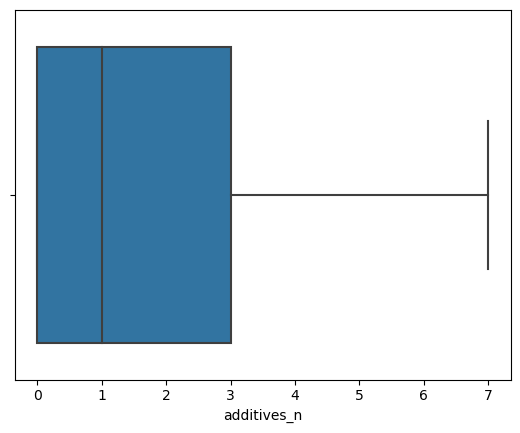

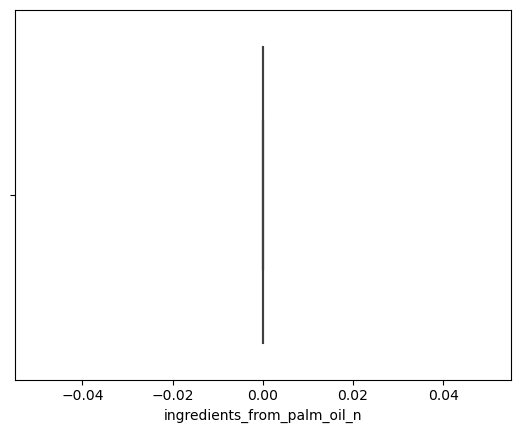

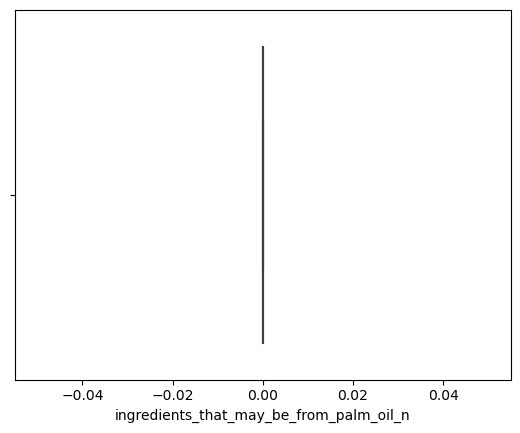

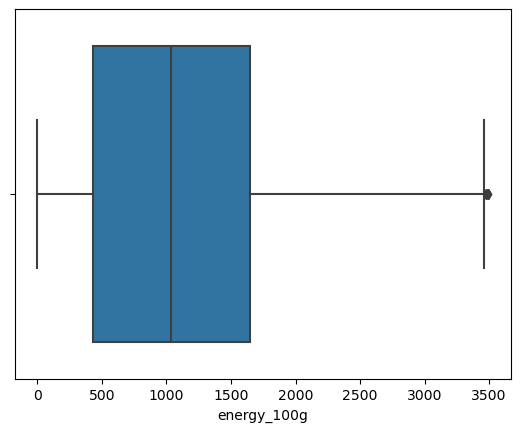

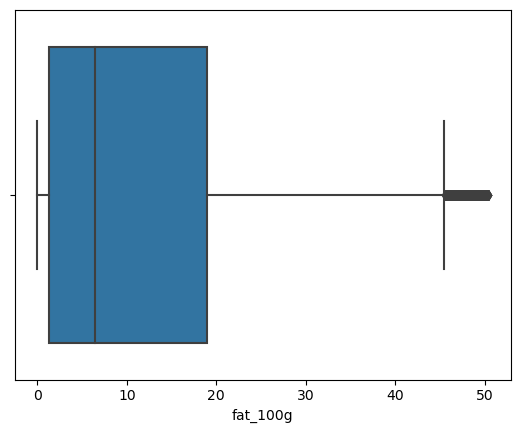

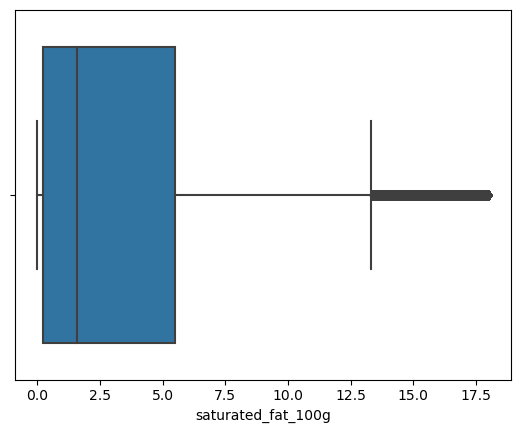

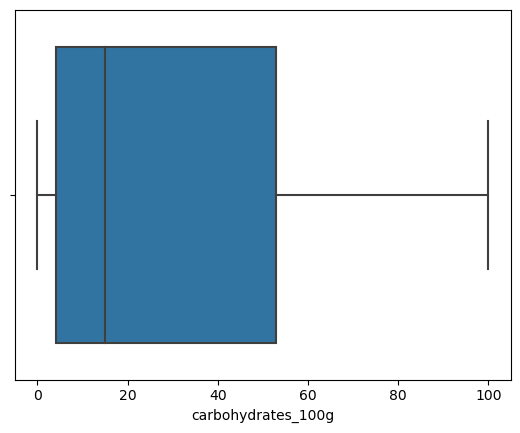

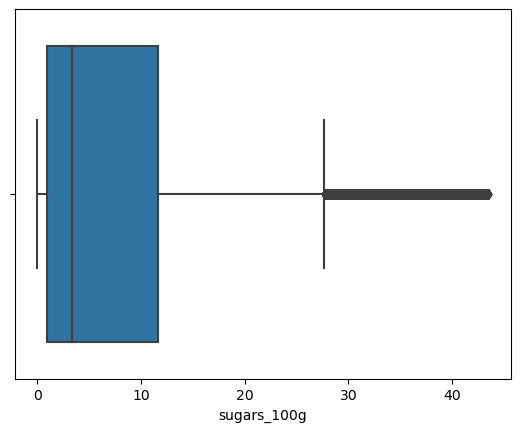

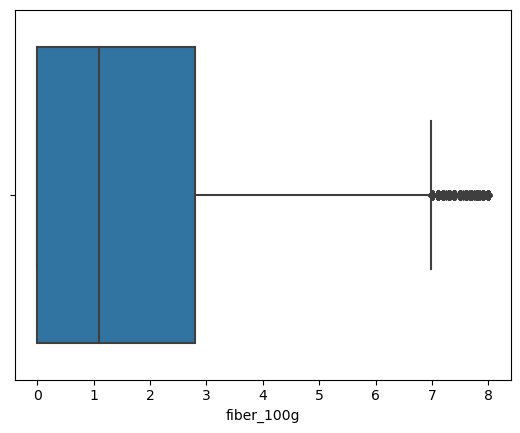

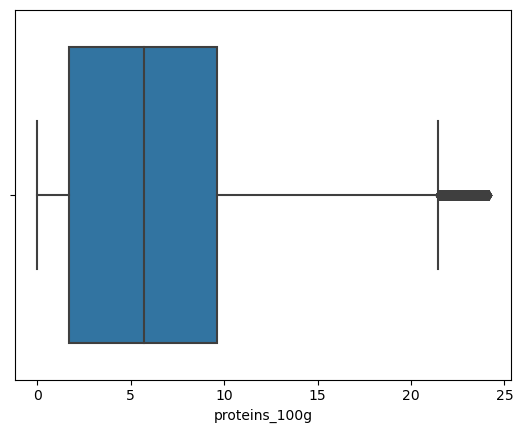

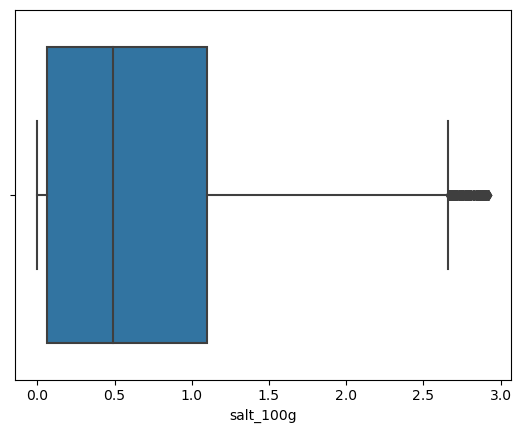

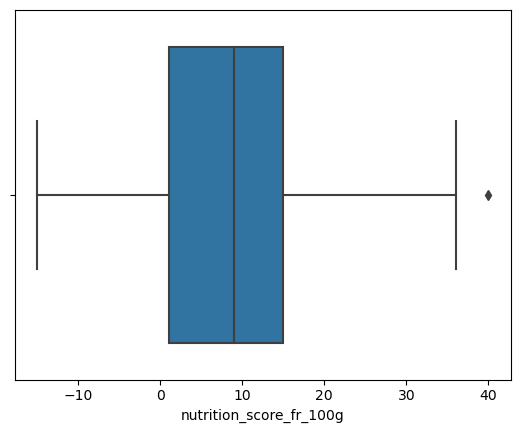

In [23]:
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        sns.boxplot(x=data[elem])
        plt.show()

On voit bien que l'echelle pour l'energie s'est adaptée, on avait donc des valeurs vraiment trop elevées.

## 2.4 Valeurs manquantes

<AxesSubplot:>

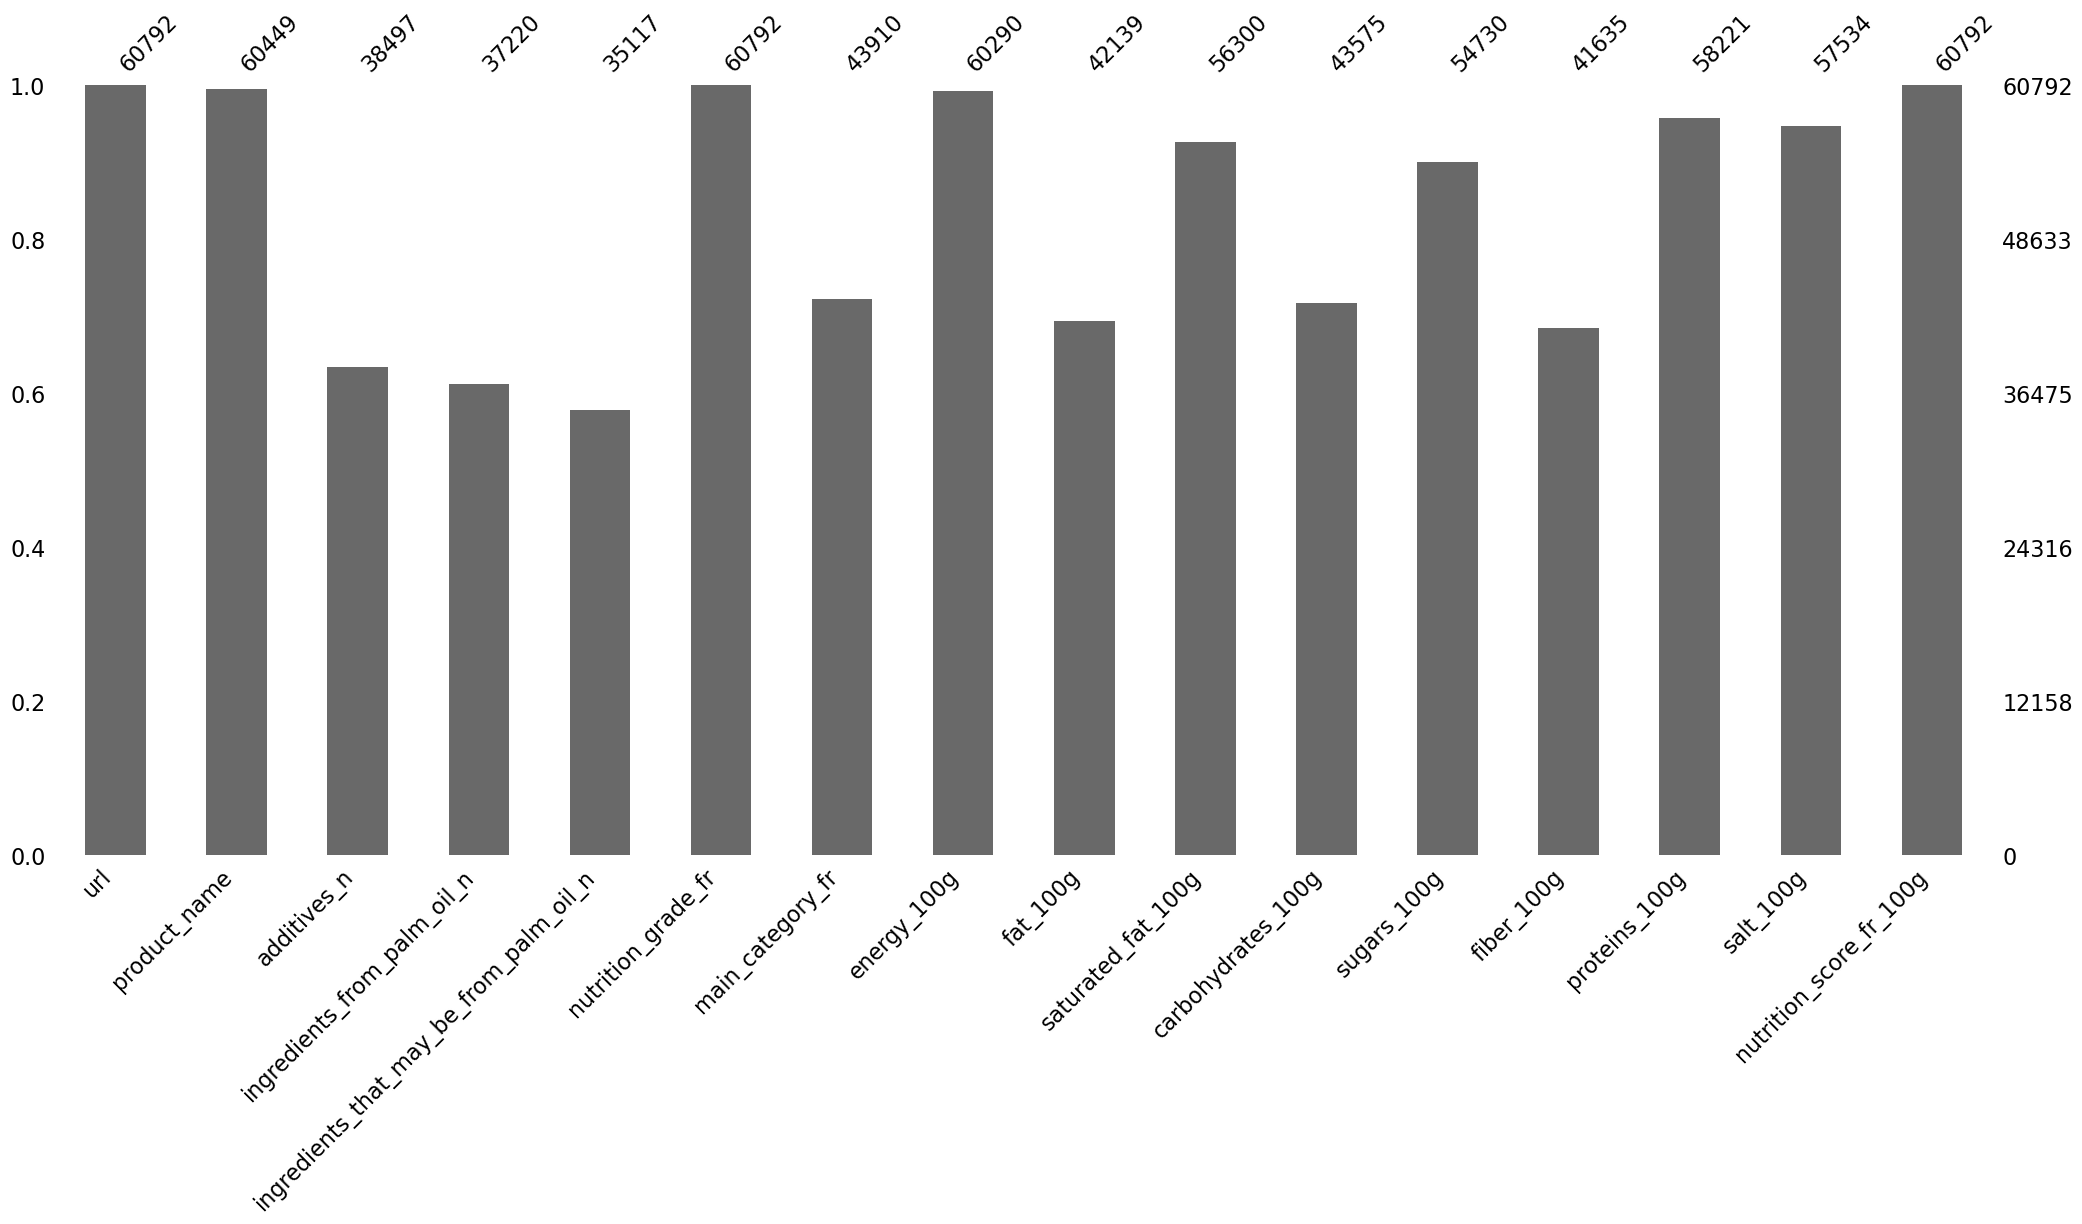

In [24]:
msno.bar(data)

In [25]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
count,38497.000000,37220.0,35117.0,60290.000000,42139.000000,56300.000000,43575.000000,54730.000000,41635.000000,58221.000000,57534.000000,60792.000000
mean,1.664493,0.0,0.0,1104.204602,11.186221,3.723543,27.884818,8.282978,1.736184,6.770511,0.663969,8.676158
std,1.902582,0.0,0.0,747.328301,11.980933,4.772805,27.239342,10.687332,1.963323,5.985936,0.680991,9.048743
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,0.000000,0.0,0.0,434.000000,1.300000,0.240000,4.200000,0.900000,0.000000,1.700000,0.060000,1.000000
50%,1.000000,0.0,0.0,1035.000000,6.400000,1.600000,15.000000,3.300000,1.100000,5.700000,0.490000,9.000000
75%,3.000000,0.0,0.0,1648.000000,19.000000,5.500000,53.000000,11.600000,2.800000,9.600000,1.100000,15.000000
max,7.000000,0.0,0.0,3494.000000,50.400000,18.000000,100.000000,43.500000,8.000000,24.140000,2.921000,40.000000


In [26]:
data.shape

(60792, 16)

In [27]:
# Permet de compter les valeurs de chaque colonne, donc les valeurs non nulles
data.count()

url                                        60792
product_name                               60449
additives_n                                38497
ingredients_from_palm_oil_n                37220
ingredients_that_may_be_from_palm_oil_n    35117
nutrition_grade_fr                         60792
main_category_fr                           43910
energy_100g                                60290
fat_100g                                   42139
saturated_fat_100g                         56300
carbohydrates_100g                         43575
sugars_100g                                54730
fiber_100g                                 41635
proteins_100g                              58221
salt_100g                                  57534
nutrition_score_fr_100g                    60792
dtype: int64

In [25]:
# On reattribue les index
data = data.reset_index(drop=True)

In [29]:
for colonne in data.columns:
    # compter le nombre de valeurs manquantes et les afficher
    n_miss = data[colonne].isna().sum()
    perc = n_miss / data.shape[0] * 100
    print("{}, missing: {} ({:.2f}%)".format(colonne, n_miss, perc ))

url, missing: 0 (0.00%)
product_name, missing: 343 (0.56%)
additives_n, missing: 22295 (36.67%)
ingredients_from_palm_oil_n, missing: 23572 (38.77%)
ingredients_that_may_be_from_palm_oil_n, missing: 25675 (42.23%)
nutrition_grade_fr, missing: 0 (0.00%)
main_category_fr, missing: 16882 (27.77%)
energy_100g, missing: 502 (0.83%)
fat_100g, missing: 18653 (30.68%)
saturated_fat_100g, missing: 4492 (7.39%)
carbohydrates_100g, missing: 17217 (28.32%)
sugars_100g, missing: 6062 (9.97%)
fiber_100g, missing: 19157 (31.51%)
proteins_100g, missing: 2571 (4.23%)
salt_100g, missing: 3258 (5.36%)
nutrition_score_fr_100g, missing: 0 (0.00%)


On peut noter les variables qui contiennent beaucoup de valeurs manquantes : 
- additives_n (36.68%)
- main_category_fr (27.78%)
- fat_100g (30.69%)
- carbohydrates_100g (28.33%)
- fiber_100g (31.51%)  
  
Toutes les autres variables ont moins de 10% de valeurs manquantes. 

In [26]:
# Determiner les données qualitatives et quantitatives
all_col = data.columns
# données qualitatives
qual_na = ['url','product_name',"nutrition_grade_fr","main_category_fr"]
# données quantitatives
quant_na = ['additives_n', 'energy_100g', 'fat_100g','saturated_fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition_score_fr_100g']

##### TESTS D'IMPUTATION

In [23]:
# Imputer en utilisant la strategy de la moyenne 
data1 = data.copy()
imp = SimpleImputer(strategy='mean')
for elem in quant_na : 
    data1[elem] = imp.fit_transform(data1[elem].values.reshape(-1, 1))

# Imputer en utilisant la strategy de la mediane 
data2 = data.copy()
imp2 = SimpleImputer(strategy='median')
for elem in quant_na : 
    data2[elem] = imp2.fit_transform(data2[elem].values.reshape(-1, 1))

# Imputer en utilisant la strategy des KNN
data3 = data.copy()
imp3 = KNNImputer(n_neighbors=2, weights="uniform")
for elem in quant_na : 
    data3[elem] = imp3.fit_transform(data3[elem].values.reshape(-1, 1))

In [171]:
'''
data1 = data.copy()
imp = SimpleImputer(strategy='mean')
for elem in quant_na : 
    data1[elem] = imp.fit_transform(data1[elem].values.reshape(-1, 1))
    
data2 = data.copy()
imp2 = SimpleImputer(strategy='median')
for elem in quant_na : 
    data2[elem] = imp2.fit_transform(data2[elem].values.reshape(-1, 1))
    
data3 = data.copy()
imp3 = KNNImputer(n_neighbors=2, weights="uniform")
for elem in quant_na : 
    data3[elem] = imp3.fit_transform(data3[elem].values.reshape(-1, 1))
    
data4 = data.copy()
imp4 = KNNImputer(n_neighbors=3)
for elem in quant_na : 
    data4[elem] = imp4.fit_transform(data4[elem].values.reshape(-1,1))
    
data5 = data.copy()
imp5 = IterativeImputer(n_nearest_features=None, imputation_order='ascending')
for elem in quant_na : 
    data5[elem] = imp5.fit_transform(data5[elem].values.reshape(-1, 1))
    
data6 = data.copy()
imp6 = IterativeImputer(estimator = RandomForestRegressor() , n_nearest_features=None, imputation_order='ascending')
for elem in quant_na : 
    data6[elem] = imp6.fit_transform(data6[elem].values.reshape(-1, 1))
    
data7 = data.copy()
imp7 = KNNImputer(n_neighbors=1, weights="uniform")
for elem in quant_na : 
    data7[elem] = imp7.fit_transform(data7[elem].values.reshape(-1, 1))
    
data8 = data.copy()
imp8 = KNNImputer(n_neighbors=2)
for elem in quant_na : 
    data8[elem] = imp8.fit_transform(data8[elem].values.reshape(-1, 1))
    
data9 = data.copy()
imp9 = KNNImputer()
for elem in quant_na : 
    data9[elem] = imp9.fit_transform(data9[elem].values.reshape(-1, 1))
'''

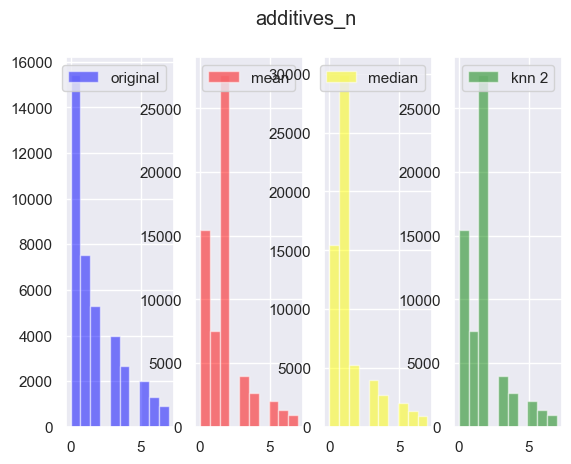

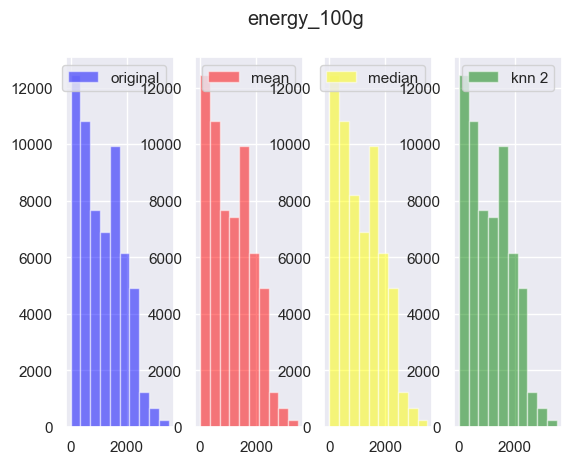

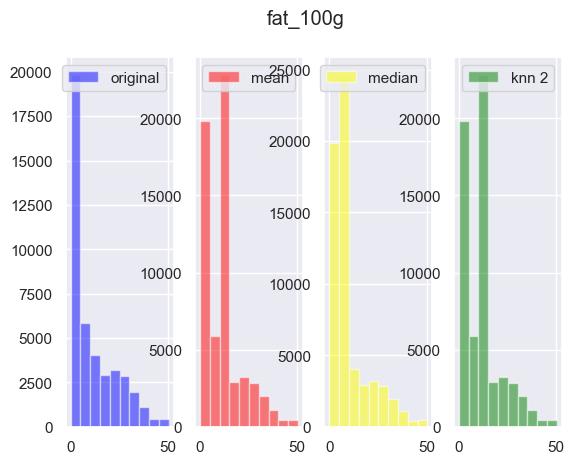

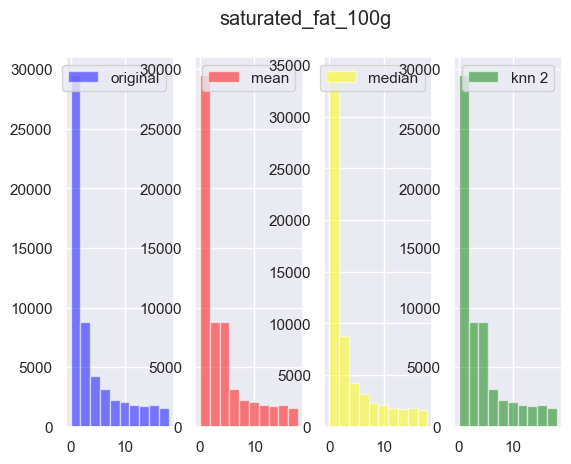

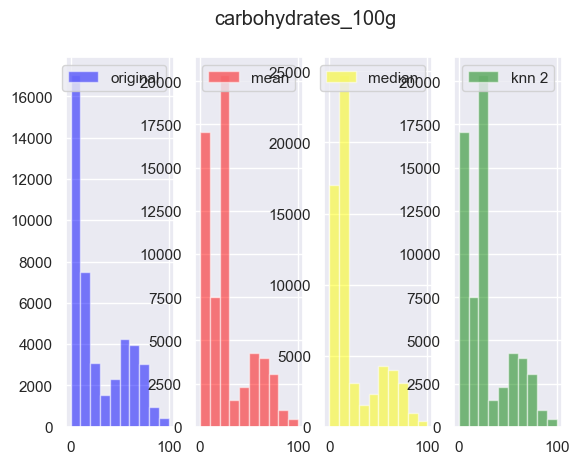

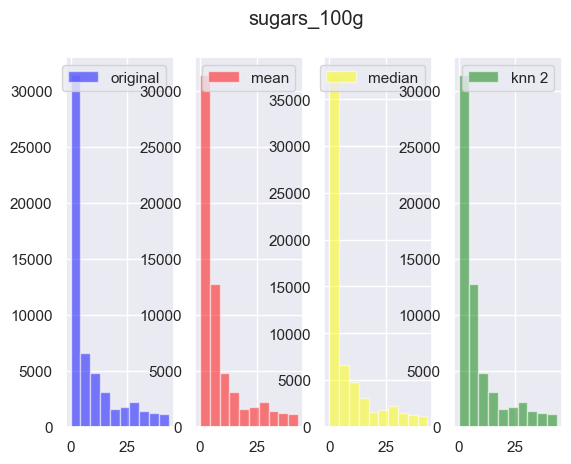

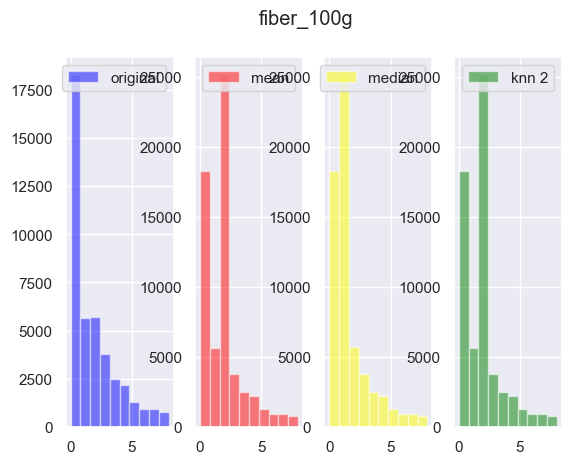

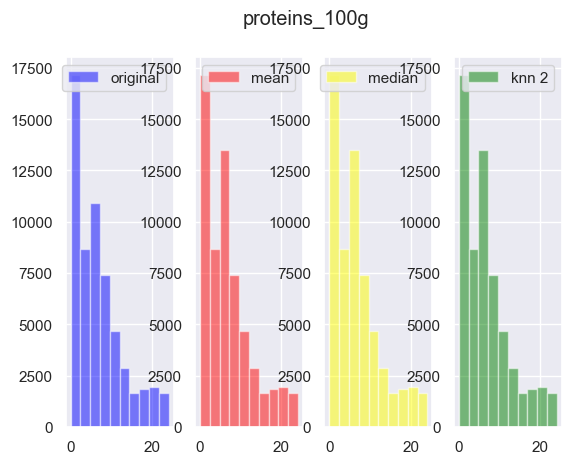

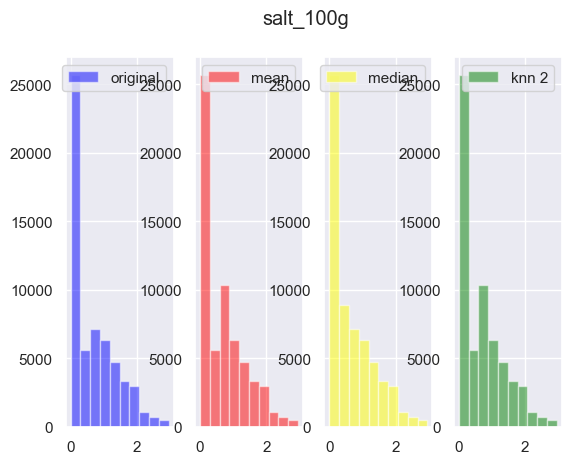

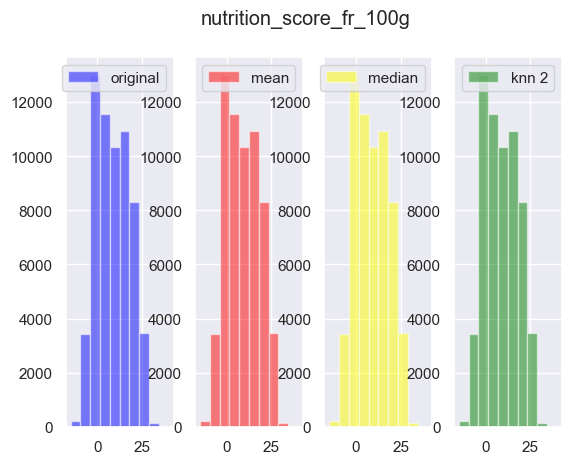

In [24]:
for elem in quant_na : 
    plt.subplot(1,4,1)
    plt.hist(data[elem].dropna(), 
         alpha=0.5, 
         label='original', color = 'blue') 
    plt.legend(loc='upper right')

    plt.subplot(1,4,2)
    plt.hist(data1[elem], 
         alpha=0.5,
         label='mean', color = 'red')
    plt.legend(loc='upper right')
  
    plt.subplot(1,4,3)
    plt.hist(data2[elem], 
         alpha=0.5,
         label='median', color = 'yellow')
    plt.legend(loc='upper right')
    
    plt.subplot(1,4,4)    
    plt.hist(data3[elem], 
         alpha=0.5,
         label='knn 2', color = 'green')
    plt.legend(loc='upper right')
    
    
    plt.suptitle(elem)
    plt.show()

On va se baser sur le KNN, en choisissant les 2 voisins les plus proches car l'utilisation de ces paramètres ne changent pas vraiment la ditribution de chaque variable. 
Et pour certaines variables nous allons retenir la methode de la mediane, qui conserve mieux la distribution initiale. 

In [27]:
imp2 = SimpleImputer(strategy='median')
imp3 = KNNImputer(n_neighbors=2, weights="uniform")

In [28]:
quant_na2 = quant_na.copy()

In [29]:
quant_na2.remove("sugars_100g")
quant_na2.remove("saturated_fat_100g")
quant_na2

['additives_n',
 'energy_100g',
 'fat_100g',
 'carbohydrates_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'nutrition_score_fr_100g']

In [30]:
for elem in quant_na2 : 
    data[elem] = imp3.fit_transform(data[elem].values.reshape(-1, 1))
    
data["sugars_100g"] = imp2.fit_transform(data["sugars_100g"].values.reshape(-1, 1))

In [31]:
data["saturated_fat_100g"] = imp2.fit_transform(data["saturated_fat_100g"].values.reshape(-1, 1))

In [126]:
data.isna().mean()

product_name               0.005643
additives_n                0.000000
nutrition_grade_fr         0.000000
main_category_fr           0.277760
energy_100g                0.000000
fat_100g                   0.000000
saturated_fat_100g         0.000000
carbohydrates_100g         0.000000
sugars_100g                0.000000
fiber_100g                 0.000000
proteins_100g              0.000000
salt_100g                  0.000000
nutrition_score_fr_100g    0.000000
dtype: float64

In [32]:
# On decide de supprimer les lignes sans nom de produit car cela ne correspond que a 0.5% de valeur et sans nom de produit il est compliqué de retenir un produit
data = data.dropna(subset = 'product_name')

In [41]:
data.shape

(61125, 14)

In [33]:
# On décide de remplacer le nom de la category par manquant pour montrer que on ne connait pas cette category mais qu'on conserve les données
newImp = SimpleImputer(strategy='constant', fill_value='manquant')
data["main_category_fr"] = newImp.fit_transform(data["main_category_fr"].values.reshape(-1, 1))

In [52]:
data.isna().mean()

url                        0.0
product_name               0.0
additives_n                0.0
nutrition_grade_fr         0.0
main_category_fr           0.0
energy_100g                0.0
fat_100g                   0.0
saturated_fat_100g         0.0
carbohydrates_100g         0.0
sugars_100g                0.0
fiber_100g                 0.0
proteins_100g              0.0
salt_100g                  0.0
nutrition_score_fr_100g    0.0
dtype: float64

<AxesSubplot:>

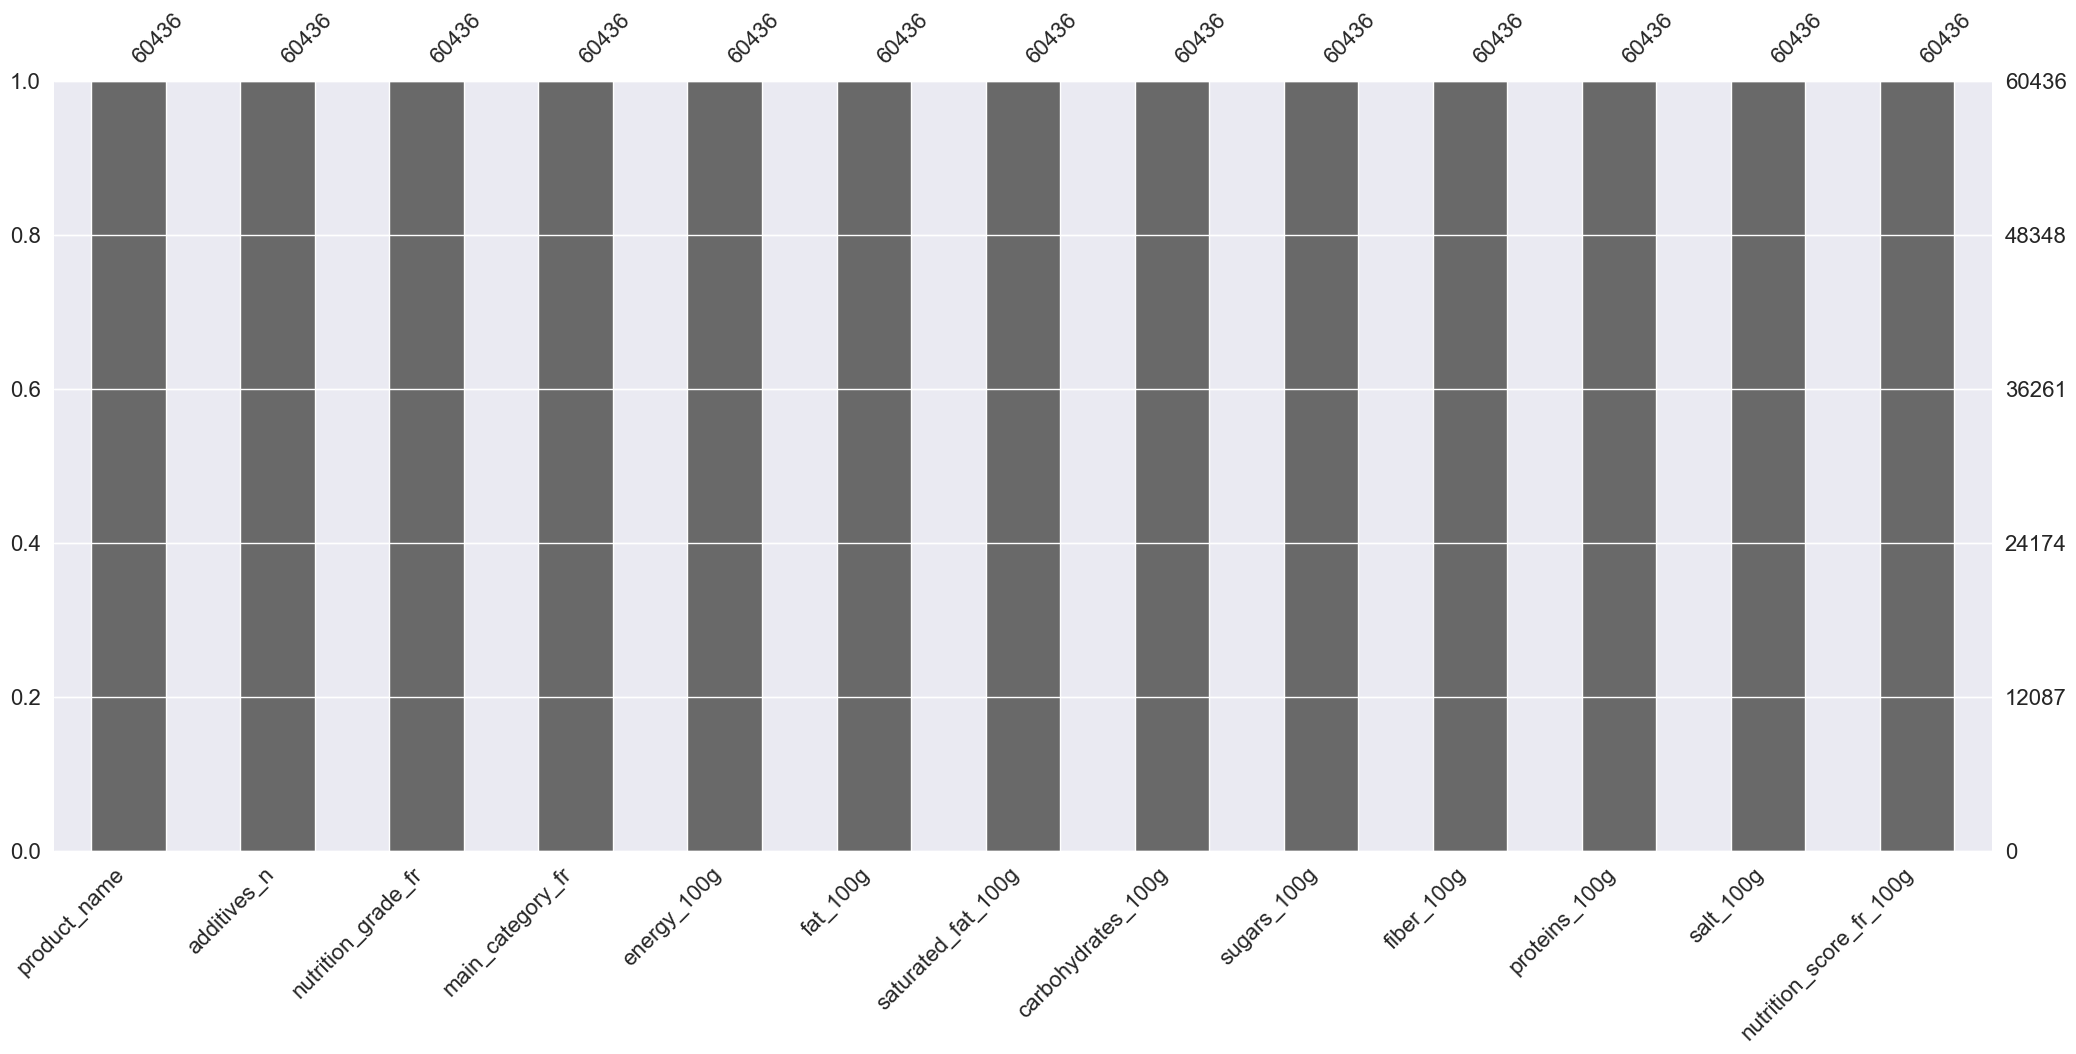

In [180]:
msno.bar(data)

On se retrouve donc avec un dataset qui ne contient plus aucune valeur manquante et que nous allons pouvoir visualiser

In [181]:
data.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
count,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000
mean,1.786700,1103.945419,11.178585,3.565322,27.863290,7.781752,1.734337,6.775141,0.663981,8.670395
std,1.526151,744.088402,9.961897,4.627010,23.042976,10.244093,1.625568,5.862860,0.662760,9.046211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,0.000000,436.000000,2.900000,0.300000,8.100000,1.000000,0.315750,1.900000,0.080000,1.000000
50%,2.000000,1042.000000,11.183505,1.600000,27.878095,3.300000,1.735763,6.000000,0.558800,9.000000
75%,2.000000,1643.000000,12.000000,4.900000,37.100000,10.400000,2.000000,9.300000,1.050000,15.000000
max,7.000000,3494.000000,50.400000,18.000000,100.000000,43.500000,8.000000,24.140000,2.921000,40.000000


On obtient les résultats statistiques pour les variables quantitatives, on remarque donc qu'on a supprimé les valeurs trop éloignées des autres donc qu'on perd un peu d'information au niveau des produis comme le sel par exemple 

In [34]:
# On sait que le nombre d'additifs est un nombre entier donc on decide d'arrondir à l'entier cette variable
data["additives_n"] = round(data["additives_n"])

In [175]:
data.describe()

,additives_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000,60436.000000
mean,1.786700,1103.945419,11.178585,3.722250,27.863290,7.781752,1.734337,6.775141,0.663981,8.670395
std,1.526151,744.088402,9.961897,4.593576,23.042976,10.244093,1.625568,5.862860,0.662760,9.046211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,0.000000,436.000000,2.900000,0.300000,8.100000,1.000000,0.315750,1.900000,0.080000,1.000000
50%,2.000000,1042.000000,11.183505,2.000000,27.878095,3.300000,1.735763,6.000000,0.558800,9.000000
75%,2.000000,1643.000000,12.000000,4.900000,37.100000,10.400000,2.000000,9.300000,1.050000,15.000000
max,7.000000,3494.000000,50.400000,18.000000,100.000000,43.500000,8.000000,24.140000,2.921000,40.000000


In [36]:
data.to_csv('dataset_projet1_nettoye.csv', index=False)